In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import mne
from mne.viz import plot_filter
import cvxopt as cv
import cvxopt.solvers
import scipy.stats as stats

#Dans Files on met l'ensemble des données des 7 expériences
#Dans Datasets on mets l'ensemble des données d'acquisitions (ECG, EDA, Respiration Rate et Acceleration)
Files = []
Datasets = []
for i in range(1,8):
    if i==1:
        Files.append(h5py.File('./Correlation_stress_datasets/1st_stress.h5', 'r'))
    elif i==2:
        Files.append(h5py.File('./Correlation_stress_datasets/2nd_stress.h5', 'r'))
    elif i==3:
        Files.append(h5py.File('./Correlation_stress_datasets/3rd_stress.h5', 'r'))
    else:
        Files.append(h5py.File(f'./Correlation_stress_datasets/{i}th_stress.h5', 'r'))
for el in Files:
    Datasets.append(el['00:07:80:0F:80:1A']['raw'])

#Le header du fichier 1st_stress.h5 qui donnne des informations supplémentaires
h1 = {"00:07:80:0F:80:1A": {"position": 0, "device": "biosignalsplux", "device name": "00:07:80:0F:80:1A", "device connection": "/dev/tty.biosignalsplux-Bluetoot", "sampling rate": 1000, "resolution": [16, 16, 16, 16], "firmware version": 775, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2020-12-14", "time": "12:53:59.523", "channels": [1, 2, 3, 4], "sensor": ["EGG", "EDA", "RESPIRATION", "XYZ"], "label": ["CH1", "CH2", "CH3", "CH4"], "column": ["nSeq", "DI", "CH1", "CH2", "CH3", "CH4"], "special": [{"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}, {"SpO2": [80, 40, 5, 4, 3, 3]}], "digital IO": [0, 1], "sleeve color": ["", "", "", ""]}}



In [ ]:
#Deux fonctions permettants d'afficher lla structures des données. Elles sont similaires mais comme on ne peut pas distinguer un Groupe HDF d'un Dataset, on doit adapter les scripts.
def afficheLabels():
    for key in dset1.keys():
        print(key)
        print(f'{list(dset1[key].keys())}')
        for subkey in dset1[key].keys():
            print(f'{dset1[key][subkey]} \n')
#afficheLabels()

def afficheLabelsSupport():
    l = 'support'
    for key in dset1['support'].keys():
        print(key)
        print(f'{dset1[l][key].keys()} \n')
        for subkey in dset1[l][key].keys():
            print(f'{dset1[l][key][subkey]} \n')
            for subsubkey in dset1[l][key][subkey].keys():
                print(f'{dset1[l][key][subkey][subsubkey]} \n')
#afficheLabelsSupport()
data = Files[0]['00:07:80:0F:80:1A']['support']['level_1000']['channel_1']['Mx']

# Architecture des données
Les fichiers x_stress.h5 sont organisé de la manière suivante
* Le nom de l'appareil '00:07:80:0F:80:1A'
    * digital : 
        * digital_1 : Grande liste de 0
    * events
        * digital : Un tableau [2,0,0,0] correspondant à la durée de l'intervalle de synchronisation
        * sync : Un tableau vide
    * plugin : Un groupe avec des Datasets vides 
    * raw :
        * channel_1 : Un tableau de N entrées correspondant aux valeurs de l'ECG
        * channel_2 : Un tableau de N entrées correspondant aux valeurs de l'EDA
        * channel_3 : Un tableau de N entrées correspondant aux valeurs du taux de respiration
        * channel_4 : Un tableau de N entrées correspondant aux valeurs de l'accéleromètre
        * nSeq : Un tableau de 0 à 330599 correspondant à l'échantillonnage
    * support : 
        * level_10 :
            * channel_1 : 
                * Mx : 
                * mean : 
                * mean_x2 : 
                * mx : 
                * sd :
                * t : 
            * channel_2 : Idem
            * channel_3 : Idem
            * channel_4 : Idem
            * dig_channel_1 :
        * level_100 : Idem avec une taille de 3306
        * level_1000 : Idem avec une taille de 330

# Conclusion
Les données à traiter se trouvent dans '/00:07:80:0F:80:1A/raw' et '/00:07:80:0F:80:1A/support/level_x' qu'ils faut examiner

In [2]:
#Fonction qui récupère les données ECG, EDA, RR et ACC de Dataset afin de les plots dans la deuxième fonction. Le paramètre nous sert à définir la taille des données que l'on veut
from sklearn import preprocessing

def collectData(i):
    data_ecg, data_eda, data_rr, data_acc = [], [],[],[]
    for j in range(len(Datasets)):
        """ normalized_ecg = preprocessing.normalize(Datasets[j]['channel_1'][:i], norm="l2")
        normalized_eda = preprocessing.normalize(Datasets[j]['channel_2'][:i], norm="l2")
        normalized_rr = preprocessing.normalize(Datasets[j]['channel_3'][:i], norm="l2")
        normalized_acc = preprocessing.normalize(Datasets[j]['channel_4'][:i], norm="l2") """
        normalized_ecg = Datasets[j]['channel_1'][:i]
        normalized_eda = Datasets[j]['channel_2'][:i]
        normalized_rr = Datasets[j]['channel_3'][:i]
        normalized_acc = Datasets[j]['channel_4'][:i]
        data_ecg.append(normalized_ecg)
        data_eda.append(normalized_eda)
        data_rr.append(normalized_rr)
        data_acc.append(normalized_acc)
    return [data_ecg, data_eda, data_rr, data_acc]

dataplot = collectData(-1)

#Fonction pour ploter les données, on sauvegarde 7 images rawdatasX.png comprenant 4 graphiques différents
def plotDatas():
    for j in range(len(Datasets)):
        i = 1
        label = ['ECG', 'EDA', 'RR', 'ACC']
        fig = plt.figure(figsize=(60,20))
        for el in dataplot:
            tm = np.linspace(0, len(el[j])//1000, len(el[j]))
            el[j] = el[j]/max(el[j])
            plt.subplot(4,1,i)
            plt.plot(tm, el[j])
            plt.title(f'Raw {label[i-1]} Acquisition')
            plt.xlabel('Acquistition')
            plt.ylabel(f'{label[i-1]} Value')
            plt.legend()
            i += 1
        plt.show()
        fig.savefig(f'rawdatas{j+1}.png')

#plotDatas()

In [ ]:
from scipy import signal
from pywt import swt, iswt
from sklearn.mixture import GaussianMixture

def FiltEDA(N_order = 2):
    sample_frequence = 1000.
    res = 16
    vcc=3
    fp = [0.35, 35]
    nyquist_frequence = sample_frequence/2.
    fig = plt.figure(figsize=(60,40), facecolor="white")
    i = 3
    b, a = signal.butter(N_order, fp[0], 'low', fs = sample_frequence)
    w, h = signal.freqs(b, a)
    plt.subplot(9,1,1)
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title(f'Butterworth filter frequency response at cutoff {fp[0]} Hz')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.axvline(fp[0], color='green') # cutoff frequency
    b1, a1 = signal.butter(N_order, fp[1], 'low', fs = sample_frequence)
    w1, h1 = signal.freqs(b1, a1)
    plt.subplot(9,1,2)
    plt.semilogx(w1, 20 * np.log10(abs(h1)))
    plt.title(f'Butterworth filter frequency response at  cutoff {fp[1]} Hz')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(fp[1], color='green') # cutoff frequency
    for el in dataplot[1]:
        signal_us = ((el / 2**res) * vcc) / 0.12
        filteredel = signal.filtfilt(b, a, np.ravel(signal_us))
        filteredel1 = signal.filtfilt(b1, a1, np.ravel(signal_us))
        time = np.linspace(0, len(el)//1000, len(el))
        #time = bsnb.generate_time(signal_us, sample_frequence)        
        plt.subplot(9,1,i)
        plt.plot(time, signal_us)
        plt.plot(time, filteredel, 'r-')
        plt.plot(time, filteredel1, 'g-')
        plt.title(f'Filtered EDA {i-2} (uS)')
        plt.xlabel('Acquistition')
        plt.ylabel(f'{i} Value')
        plt.legend()
        i += 1
    plt.show()
    fig.savefig(f'filterededa_{N_order}_{fp[0]}_{fp[1]}.png', facecolor="white")

for j in range(1, 9):
    FiltEDA(j)

6
7
6
7
6
7
8


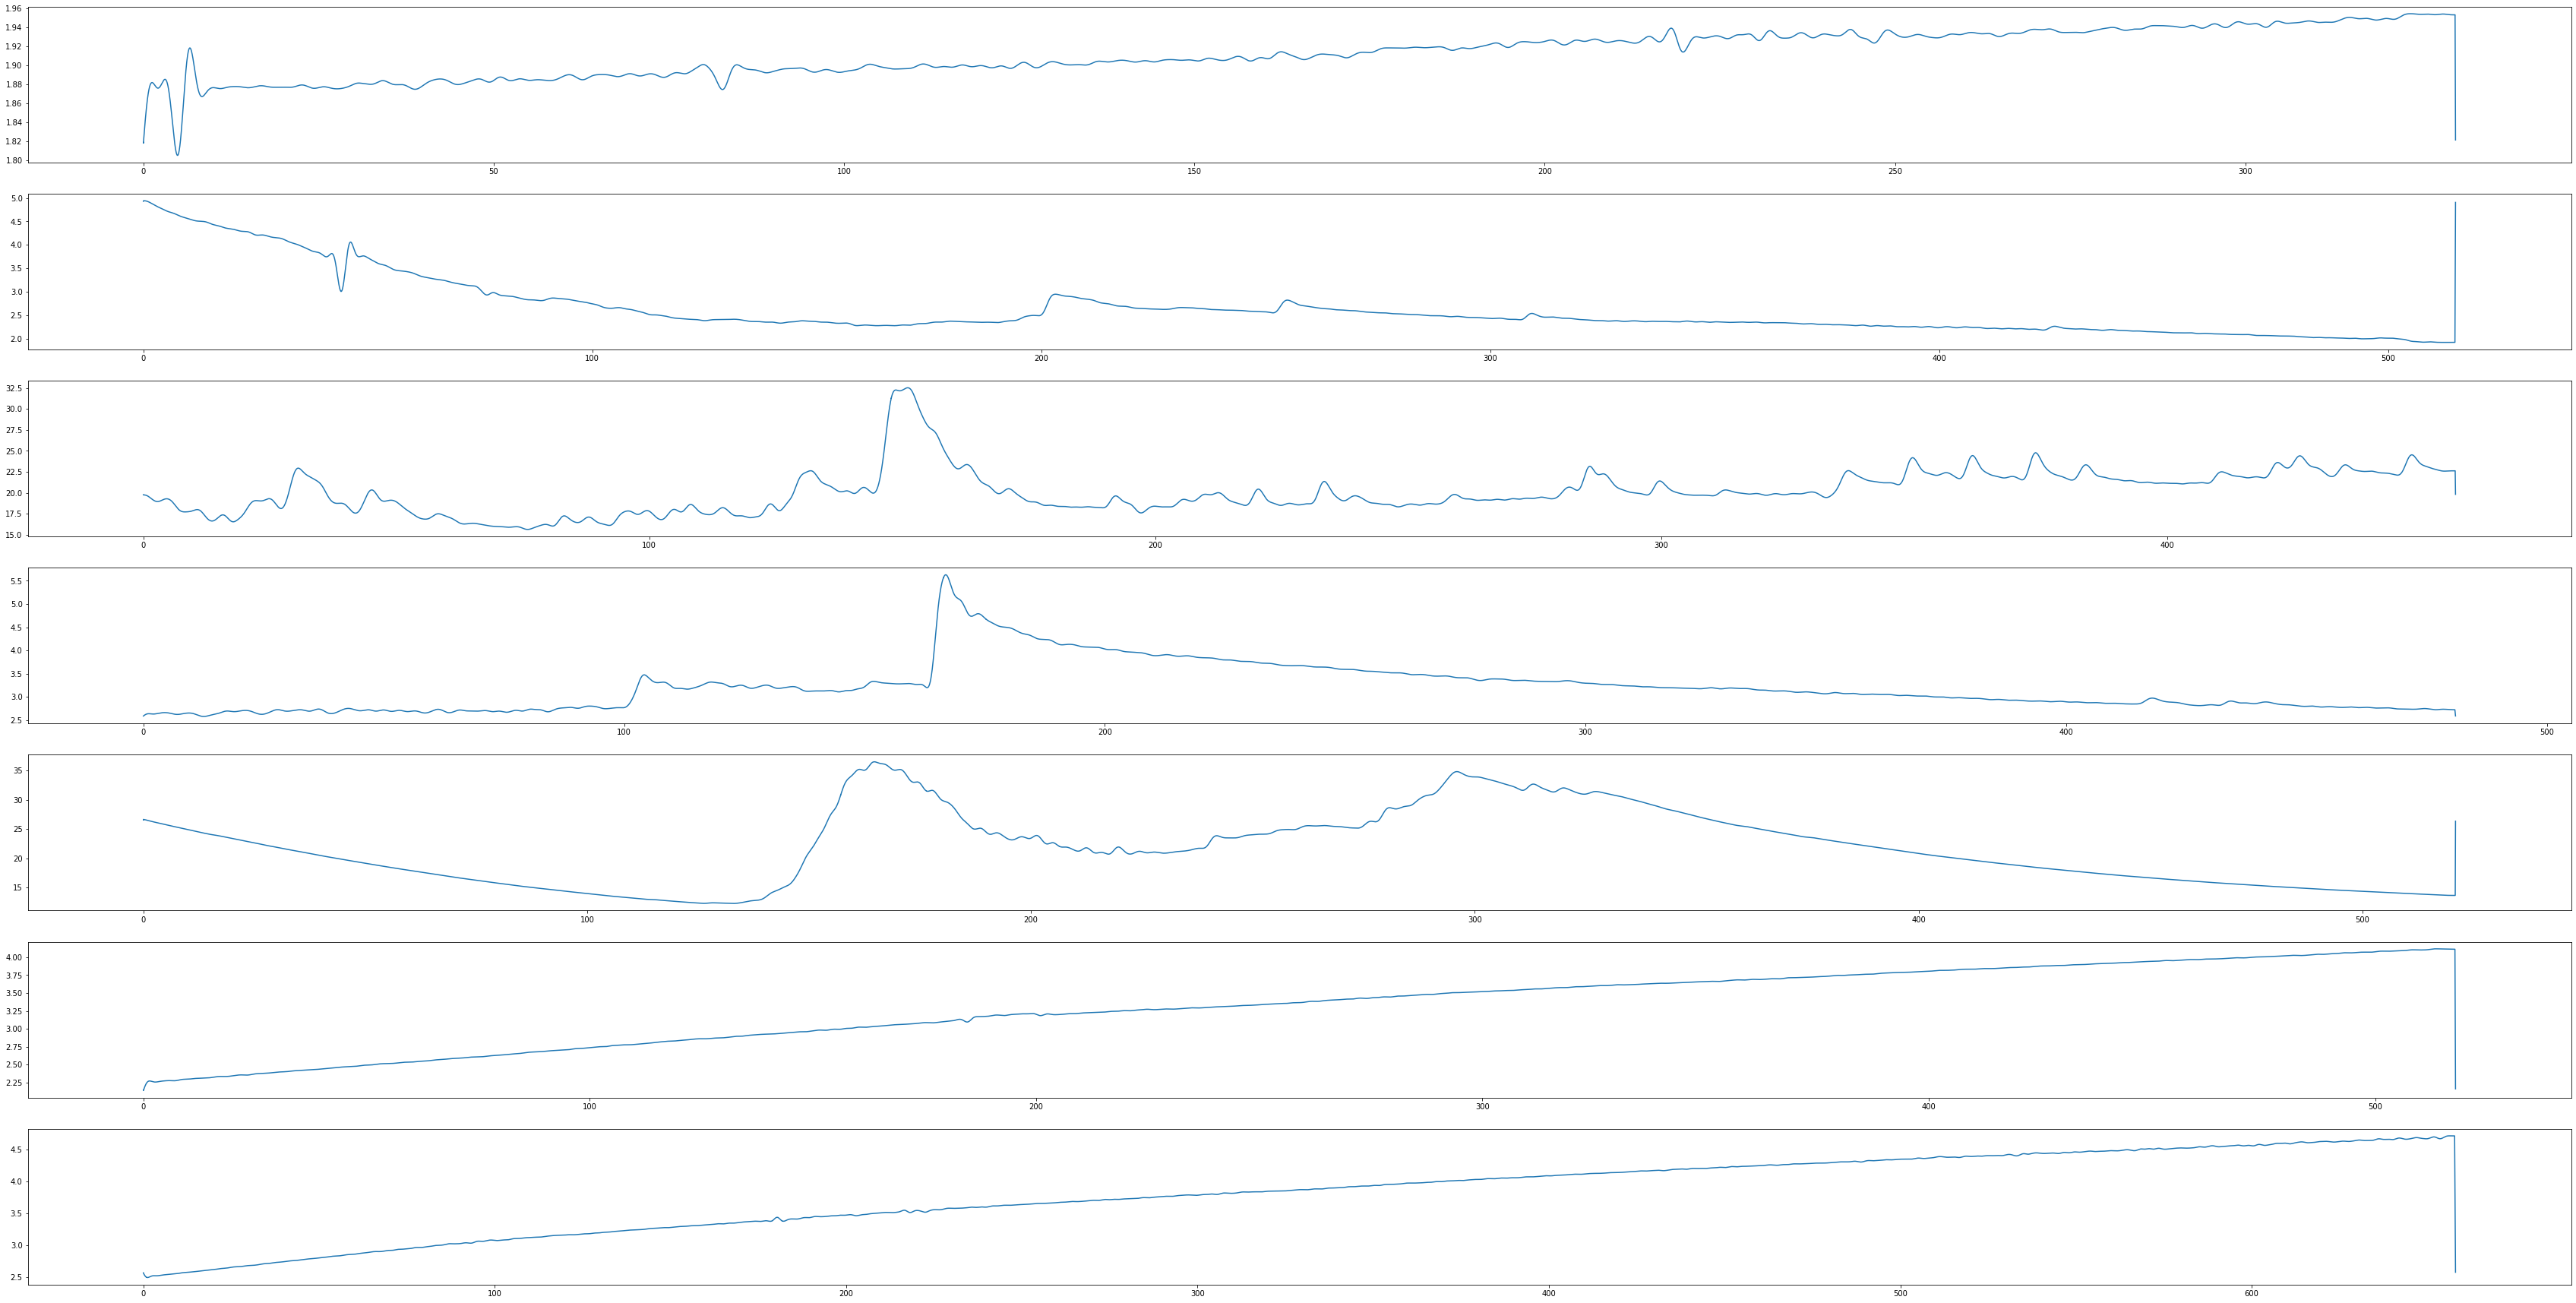

In [7]:
#import biosignalsnotebooks as bsnb
from scipy.stats import norm
from copy import deepcopy
from scipy import signal
from pywt import swt, iswt, swt_max_level
from sklearn.mixture import GaussianMixture

def SWTLevel(nb):
    a = nb//64
    return a*64

res = 16
vcc = 3
def processEDA():
    fig = plt.figure(figsize=(60,40), facecolor="white")
    b, a = signal.butter(4, 0.35, 'low', fs = 1000.)
    ligne = 1
    for el in dataplot[1]:
        signal_us = ((el / 2**res) * vcc) / 0.12
        signal_us_low_pass = signal.filtfilt(b, a, np.ravel(signal_us))
        N = len(signal_us_low_pass)
        swtN = SWTLevel(N)
        lvl = swt_max_level(swtN)
        print(lvl)
        swt_orig_coeffs = swt(signal_us_low_pass[:swtN], "haar", level=lvl)
        detail_coeffs = swt_orig_coeffs[0][1]
        scaling_coeffs = swt_orig_coeffs[0][0]
        time1 = np.linspace(0, swtN//1000, swtN)


        gaussian_mixt = GaussianMixture(n_components=2, covariance_type="spherical")
        detail_coeffs_col = np.reshape(detail_coeffs, (len(detail_coeffs), 1))
        gaussian_mixt.fit(detail_coeffs_col)
        norm_1 = norm(loc=gaussian_mixt.means_[0][0], scale=np.sqrt(gaussian_mixt.covariances_[0])) 
        norm_2 = norm(loc=gaussian_mixt.means_[1][0], scale=np.sqrt(gaussian_mixt.covariances_[1])) 
        weight_1 = gaussian_mixt.weights_[0]
        weight_2 = gaussian_mixt.weights_[1]
        sort_detail_coeffs = np.sort(detail_coeffs)
        norm_1_cdf = norm_1.cdf(sort_detail_coeffs)
        norm_2_cdf = norm_2.cdf(sort_detail_coeffs)
        cdf_mixt = weight_1 * norm_1_cdf + weight_2 * norm_2_cdf

        art_prop = 0.01 # Artifact proportion value.
        low_thr = None 
        high_thr = None
        # Check when the CDF mixture function reaches values art_prop / 2 and 1 - art_prop / 2.
        for i in range(0, len(norm_1_cdf)):
            # Low threshold clause.
            if cdf_mixt[i] - cdf_mixt[0] >= art_prop and low_thr == None:
                low_thr = sort_detail_coeffs[i]
            # High threshold clause.
            if cdf_mixt[-1] - cdf_mixt[i] <= art_prop and high_thr == None:
                high_thr = sort_detail_coeffs[i]
        
        filt_detail_coeffs = deepcopy(detail_coeffs)
        count_1 = 0
        count_2 = 0
        for j in range(0, len(filt_detail_coeffs)):
            if detail_coeffs[j] <= low_thr or detail_coeffs[j] >= high_thr:
                filt_detail_coeffs[j] = 0
            else:
                continue
        # Update of the SWT decomposition tupple.
        swt_coeffs = [(np.array(scaling_coeffs), np.array(filt_detail_coeffs))]
        rec_signal = iswt(swt_coeffs, "haar")
        plt.subplot(9, 1, ligne)
        ligne += 1
        plt.plot(time1, rec_signal)
    plt.show()
    fig.savefig(f'processedEDA.png', facecolor="white")

processEDA()

     pcost       dcost       gap    pres   dres
 0: -1.2999e+04 -1.2513e+04  5e+05  7e+02  3e+02
 1: -1.2932e+04 -9.4758e+04  1e+05  1e+02  6e+01
 2: -1.3568e+04 -6.5380e+04  5e+04  5e+01  2e+01
 3: -1.3860e+04 -3.0184e+04  2e+04  1e+01  6e+00
 4: -1.3982e+04 -2.5439e+04  1e+04  6e+00  3e+00
 5: -1.4015e+04 -2.3445e+04  9e+03  4e+00  2e+00
 6: -1.4125e+04 -1.9763e+04  6e+03  2e+00  1e+00
 7: -1.4115e+04 -1.9368e+04  5e+03  2e+00  8e-01
 8: -1.4312e+04 -1.6293e+04  2e+03  5e-01  2e-01
 9: -1.4383e+04 -1.5750e+04  1e+03  3e-01  1e-01
10: -1.4666e+04 -1.5249e+04  6e+02  8e-02  4e-02
11: -1.4698e+04 -1.5204e+04  5e+02  6e-02  3e-02
12: -1.4916e+04 -1.5091e+04  2e+02  2e-02  8e-03
13: -1.4928e+04 -1.5085e+04  2e+02  1e-02  6e-03
14: -1.4995e+04 -1.5065e+04  7e+01  4e-03  2e-03
15: -1.5014e+04 -1.5061e+04  5e+01  2e-03  7e-04
16: -1.5038e+04 -1.5056e+04  2e+01  5e-04  2e-04
17: -1.5039e+04 -1.5056e+04  2e+01  4e-04  2e-04
18: -1.5048e+04 -1.5055e+04  7e+00  1e-04  5e-05
19: -1.5048e+04 -1.50

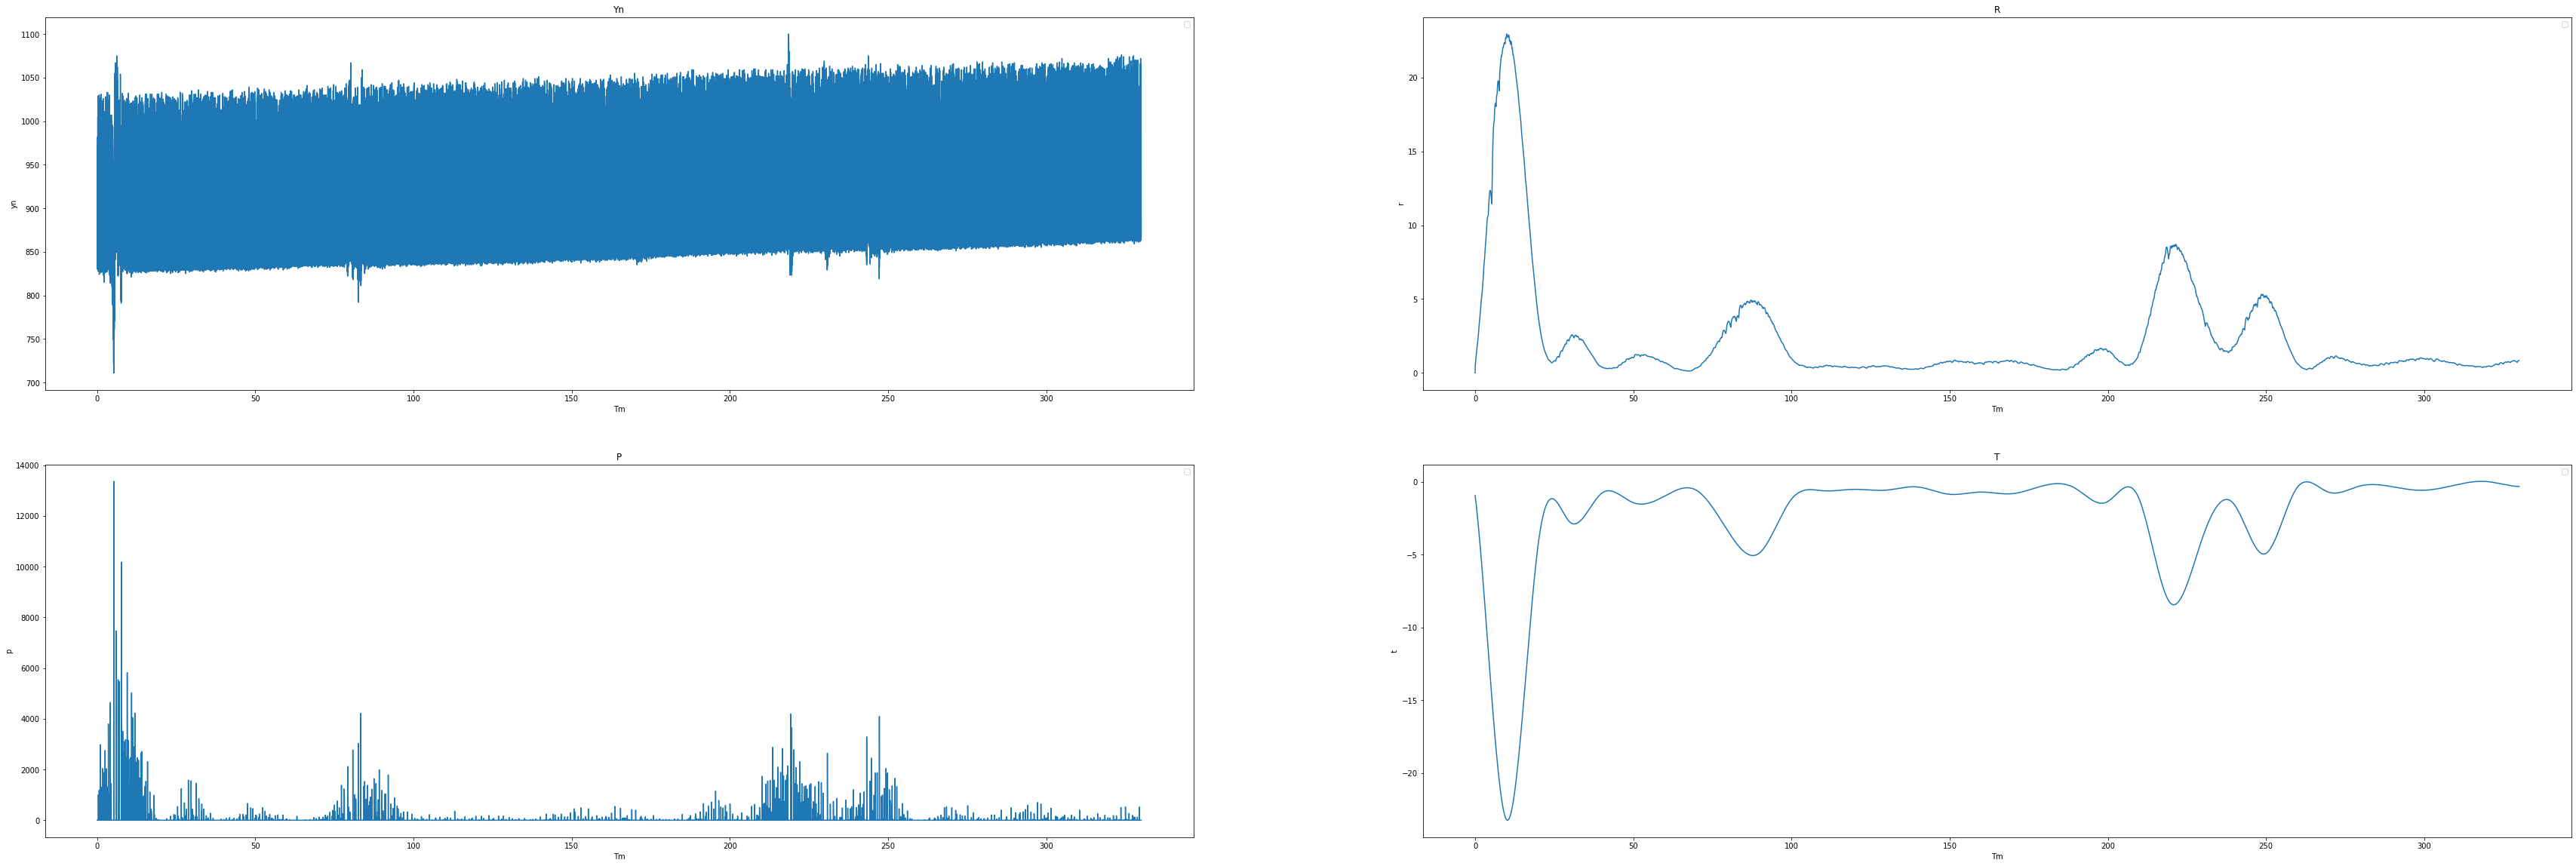

     pcost       dcost       gap    pres   dres
 0: -2.3928e+05 -2.3831e+05  9e+05  9e+02  8e+01
 1: -2.3918e+05 -3.7344e+05  2e+05  2e+02  1e+01
 2: -2.3951e+05 -3.0284e+05  7e+04  5e+01  4e+00
 3: -2.3959e+05 -2.6608e+05  3e+04  2e+01  1e+00
 4: -2.3962e+05 -2.6525e+05  3e+04  2e+01  1e+00
 5: -2.3975e+05 -2.5577e+05  2e+04  9e+00  8e-01
 6: -2.3979e+05 -2.5538e+05  2e+04  8e+00  7e-01
 7: -2.4004e+05 -2.5057e+05  1e+04  5e+00  4e-01
 8: -2.4006e+05 -2.5051e+05  1e+04  5e+00  4e-01
 9: -2.4031e+05 -2.4832e+05  8e+03  3e+00  3e-01
10: -2.4050e+05 -2.4642e+05  6e+03  2e+00  1e-01
11: -2.4051e+05 -2.4578e+05  5e+03  1e+00  1e-01
12: -2.4077e+05 -2.4384e+05  3e+03  7e-01  6e-02
13: -2.4077e+05 -2.4381e+05  3e+03  7e-01  6e-02
14: -2.4103e+05 -2.4273e+05  2e+03  3e-01  2e-02
15: -2.4120e+05 -2.4227e+05  1e+03  8e-02  6e-03
16: -2.4145e+05 -2.4214e+05  7e+02  2e-02  2e-03
17: -2.4176e+05 -2.4209e+05  3e+02  8e-03  7e-04
18: -2.4189e+05 -2.4207e+05  2e+02  3e-03  2e-04
19: -2.4198e+05 -2.42

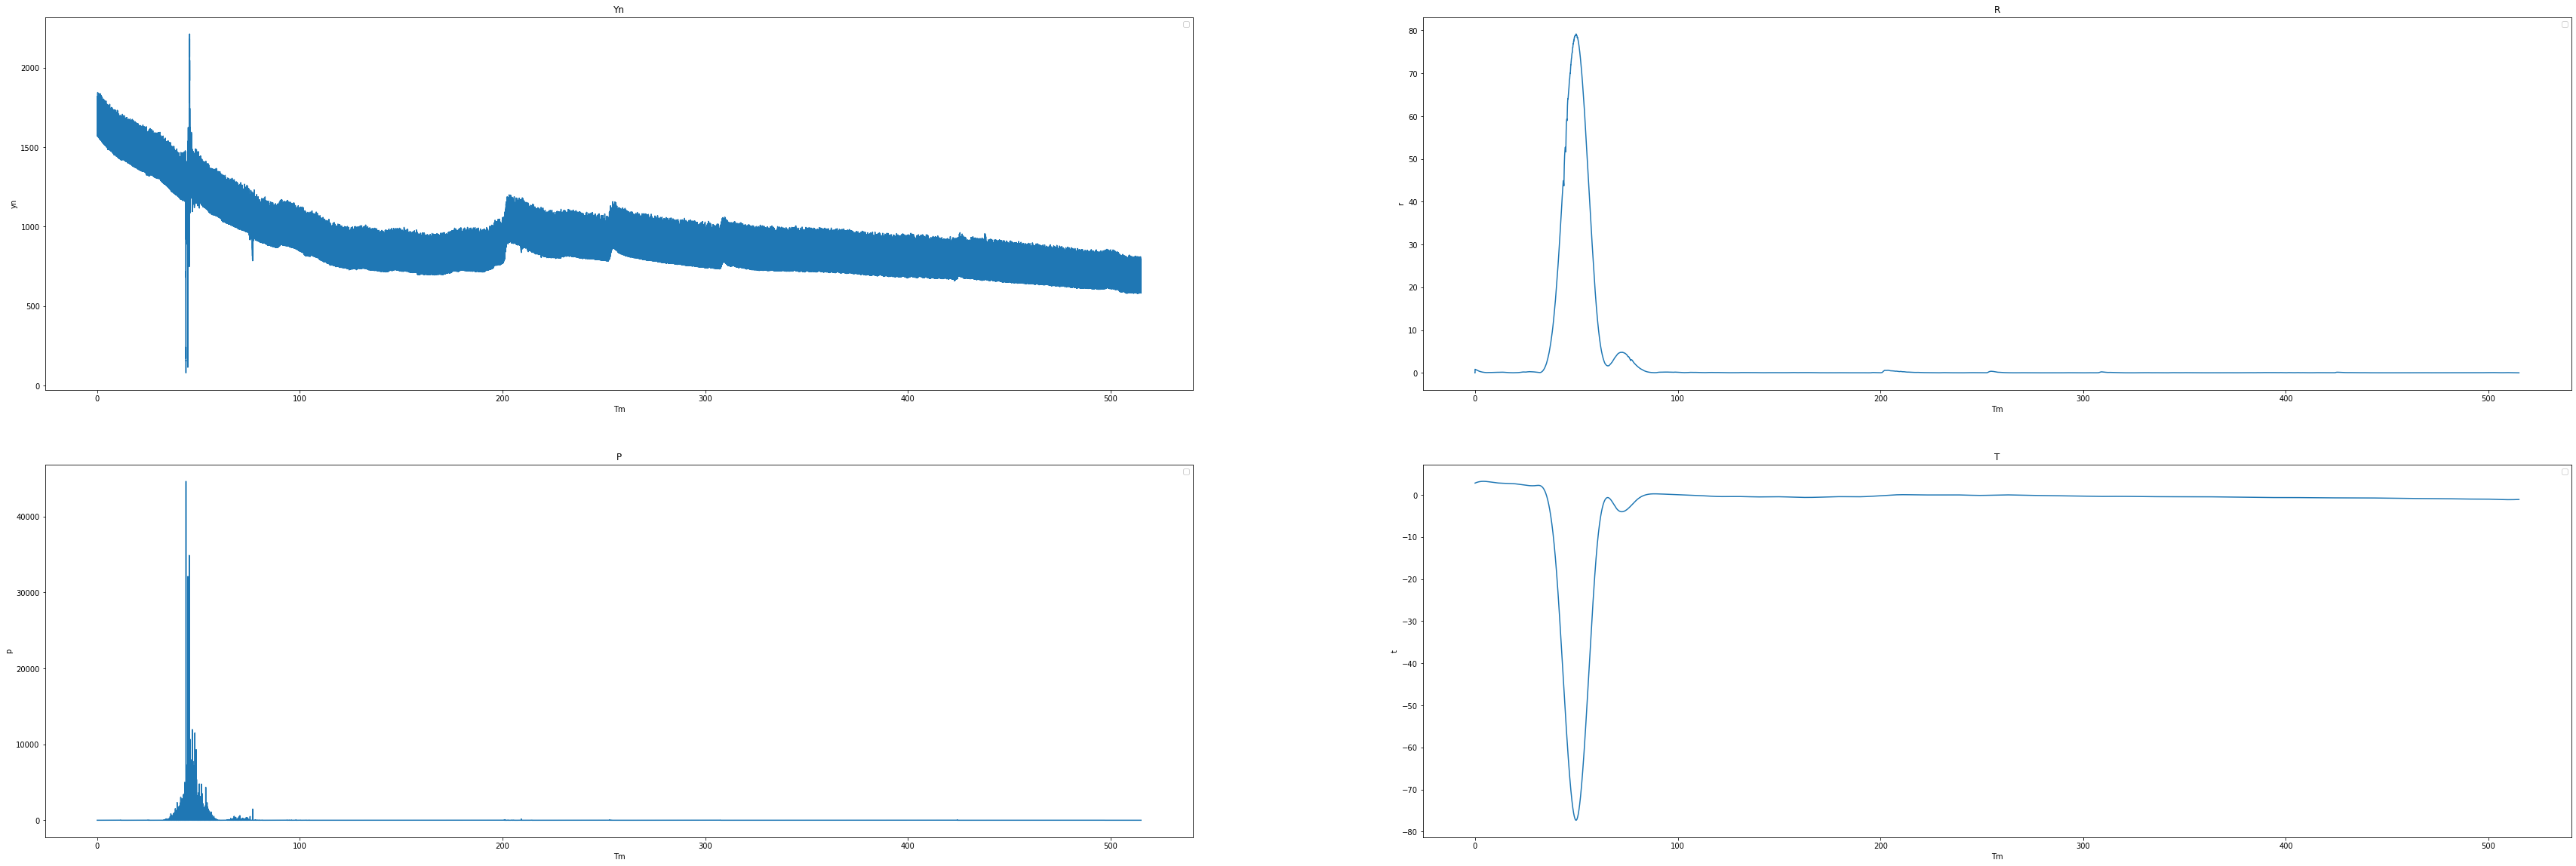

     pcost       dcost       gap    pres   dres
 0: -2.2068e+05 -2.1190e+05  1e+06  1e+03  1e+02
 1: -2.2534e+05 -4.2282e+05  2e+05  2e+02  2e+01
 2: -2.2759e+05 -2.6726e+05  4e+04  3e+01  3e+00
 3: -2.2789e+05 -2.3491e+05  7e+03  5e+00  5e-01
 4: -2.2796e+05 -2.2906e+05  1e+03  3e-01  3e-02
 5: -2.2840e+05 -2.2871e+05  3e+02  7e-02  8e-03
 6: -2.2844e+05 -2.2868e+05  2e+02  5e-02  6e-03
 7: -2.2851e+05 -2.2863e+05  1e+02  2e-02  2e-03
 8: -2.2857e+05 -2.2860e+05  3e+01  3e-03  3e-04
 9: -2.2857e+05 -2.2859e+05  2e+01  1e-03  1e-04
10: -2.2858e+05 -2.2859e+05  5e+00  2e-04  2e-05
11: -2.2858e+05 -2.2859e+05  4e+00  1e-04  1e-05
12: -2.2858e+05 -2.2858e+05  1e+00  3e-05  3e-06
13: -2.2858e+05 -2.2858e+05  1e+00  2e-05  2e-06
14: -2.2858e+05 -2.2858e+05  4e-01  5e-06  6e-07
15: -2.2858e+05 -2.2858e+05  3e-01  4e-06  5e-07
16: -2.2858e+05 -2.2858e+05  1e-01  8e-07  2e-07
17: -2.2858e+05 -2.2858e+05  1e-01  6e-07  2e-07
18: -2.2858e+05 -2.2858e+05  4e-02  2e-07  2e-07
No handles with label

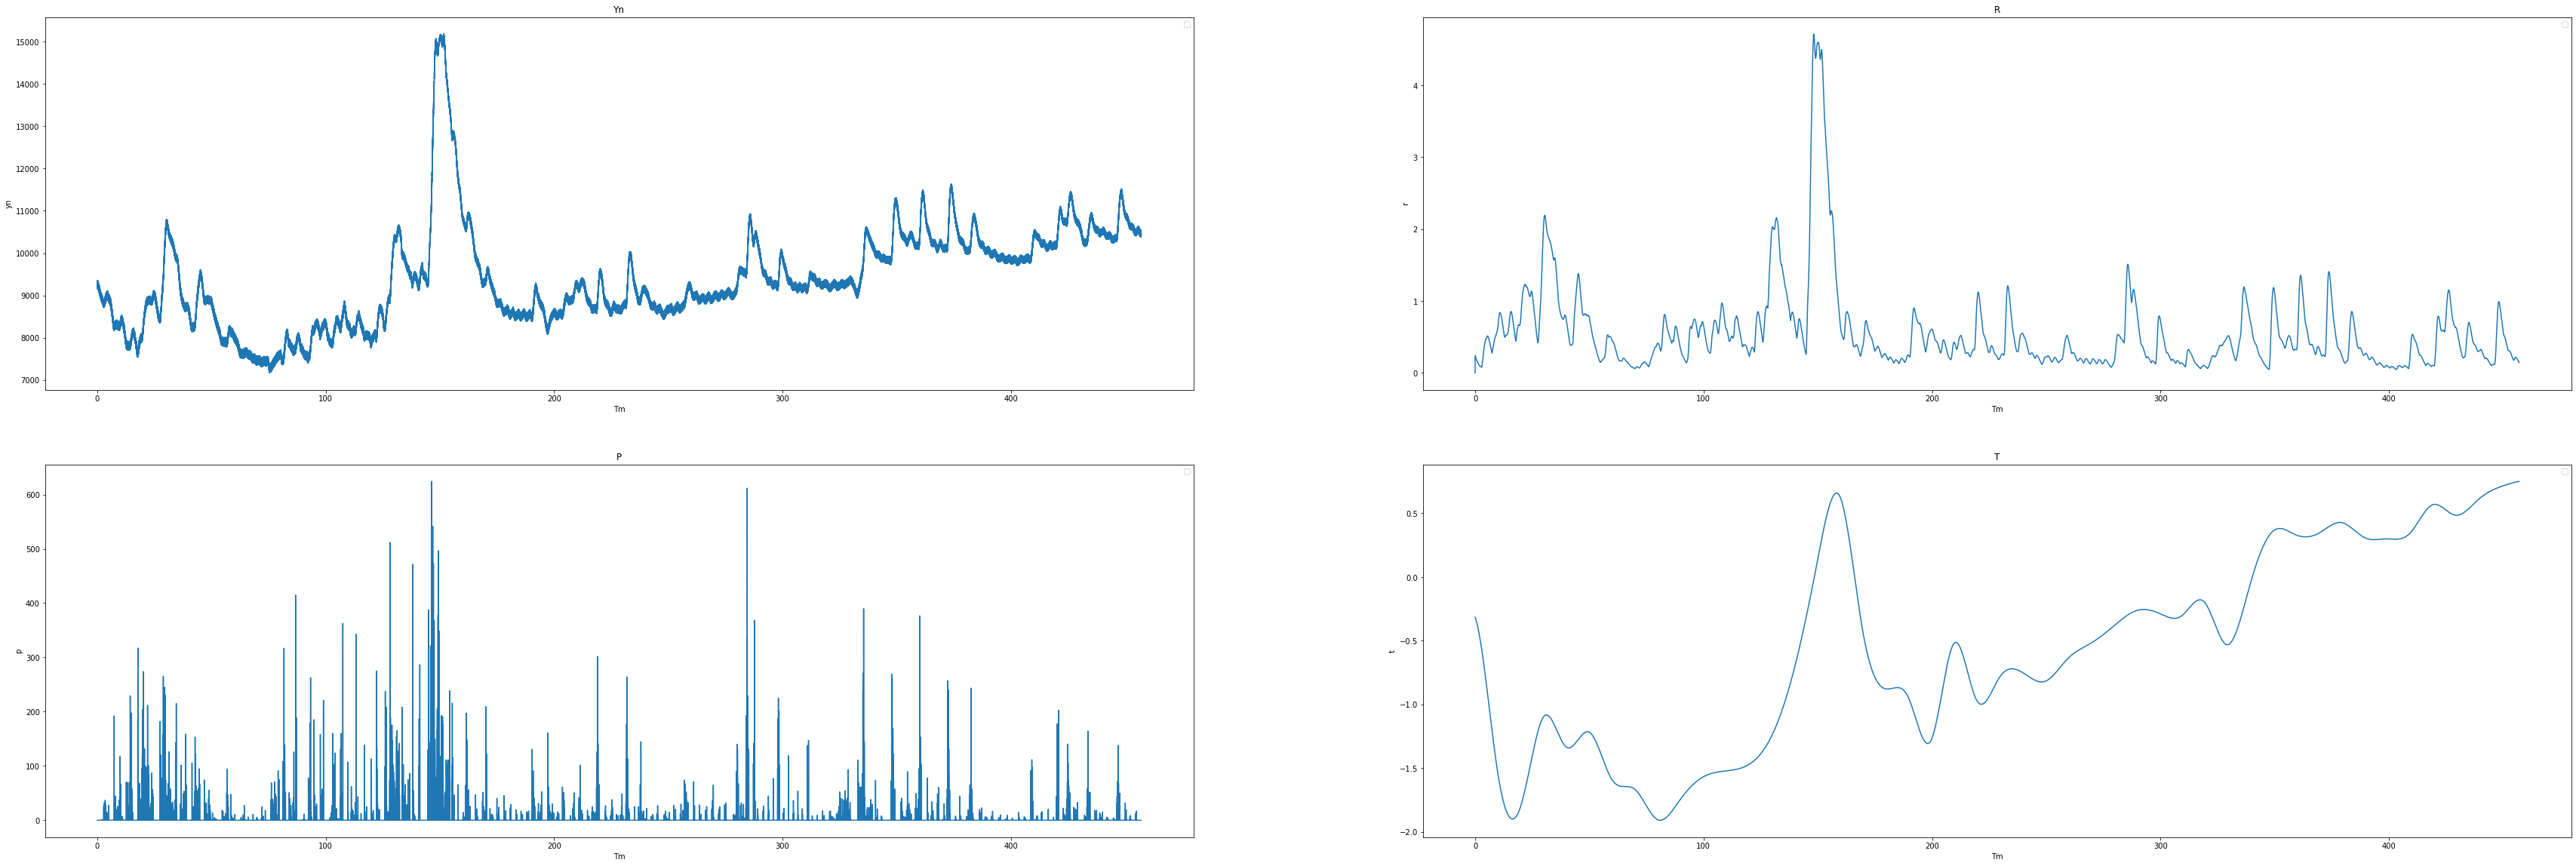

     pcost       dcost       gap    pres   dres
 0: -2.2328e+05 -2.1917e+05  1e+06  1e+03  2e+02
 1: -2.2523e+05 -4.5913e+05  3e+05  2e+02  4e+01
 2: -2.2595e+05 -2.7358e+05  5e+04  3e+01  5e+00
 3: -2.2606e+05 -2.3523e+05  9e+03  5e+00  8e-01
 4: -2.2598e+05 -2.2901e+05  3e+03  1e+00  2e-01
 5: -2.2610e+05 -2.2724e+05  1e+03  2e-01  3e-02
 6: -2.2660e+05 -2.2689e+05  3e+02  3e-02  5e-03
 7: -2.2664e+05 -2.2687e+05  2e+02  2e-02  3e-03
 8: -2.2675e+05 -2.2686e+05  1e+02  8e-03  1e-03
 9: -2.2680e+05 -2.2684e+05  4e+01  3e-03  5e-04
10: -2.2681e+05 -2.2684e+05  3e+01  6e-04  1e-04
11: -2.2683e+05 -2.2684e+05  9e+00  1e-04  2e-05
12: -2.2683e+05 -2.2684e+05  9e+00  1e-04  2e-05
13: -2.2683e+05 -2.2684e+05  4e+00  3e-05  6e-06
14: -2.2683e+05 -2.2684e+05  4e+00  3e-05  5e-06
15: -2.2683e+05 -2.2684e+05  1e+00  5e-06  1e-06
16: -2.2683e+05 -2.2684e+05  1e+00  4e-06  7e-07
17: -2.2683e+05 -2.2683e+05  4e-01  8e-07  7e-07
18: -2.2683e+05 -2.2683e+05  4e-01  6e-07  6e-07
19: -2.2683e+05 -2.26

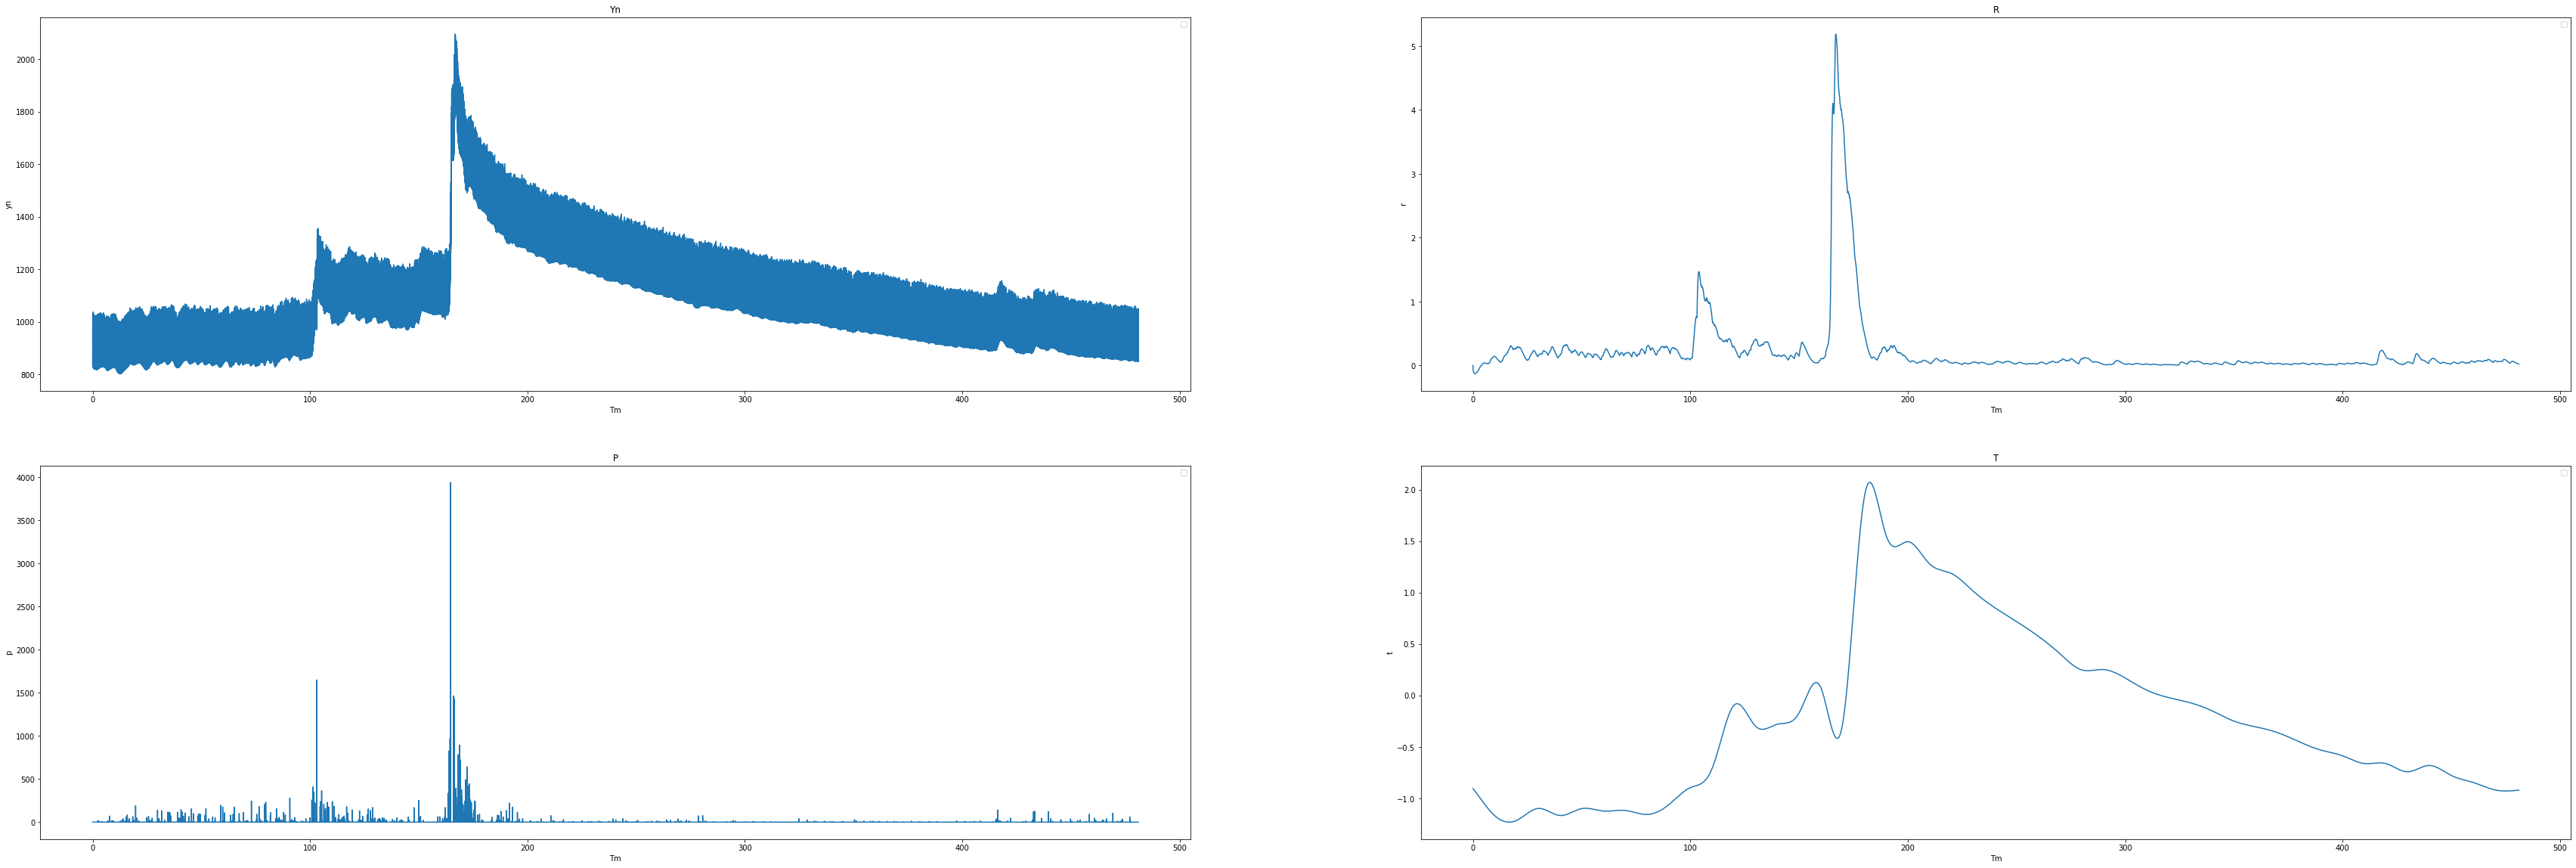

     pcost       dcost       gap    pres   dres
 0: -2.6072e+05 -2.6014e+05  6e+05  8e+02  9e+01
 1: -2.6040e+05 -2.8540e+05  3e+04  3e+01  4e+00
 2: -2.6046e+05 -2.6322e+05  3e+03  3e+00  4e-01
 3: -2.6056e+05 -2.6091e+05  4e+02  3e-02  4e-03
 4: -2.6084e+05 -2.6089e+05  5e+01  5e-03  6e-04
 5: -2.6087e+05 -2.6089e+05  2e+01  8e-04  9e-05
 6: -2.6088e+05 -2.6088e+05  8e+00  3e-04  3e-05
 7: -2.6088e+05 -2.6088e+05  3e+00  8e-05  9e-06
 8: -2.6088e+05 -2.6088e+05  9e-01  2e-05  2e-06
 9: -2.6088e+05 -2.6088e+05  3e-01  2e-06  3e-07
10: -2.6088e+05 -2.6088e+05  2e-01  2e-06  2e-07
11: -2.6088e+05 -2.6088e+05  8e-02  4e-07  1e-07
12: -2.6088e+05 -2.6088e+05  7e-02  3e-07  8e-08
13: -2.6088e+05 -2.6088e+05  2e-02  6e-08  1e-07
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
Terminated (singular KKT matrix).
No handles with labels found to put in legend.


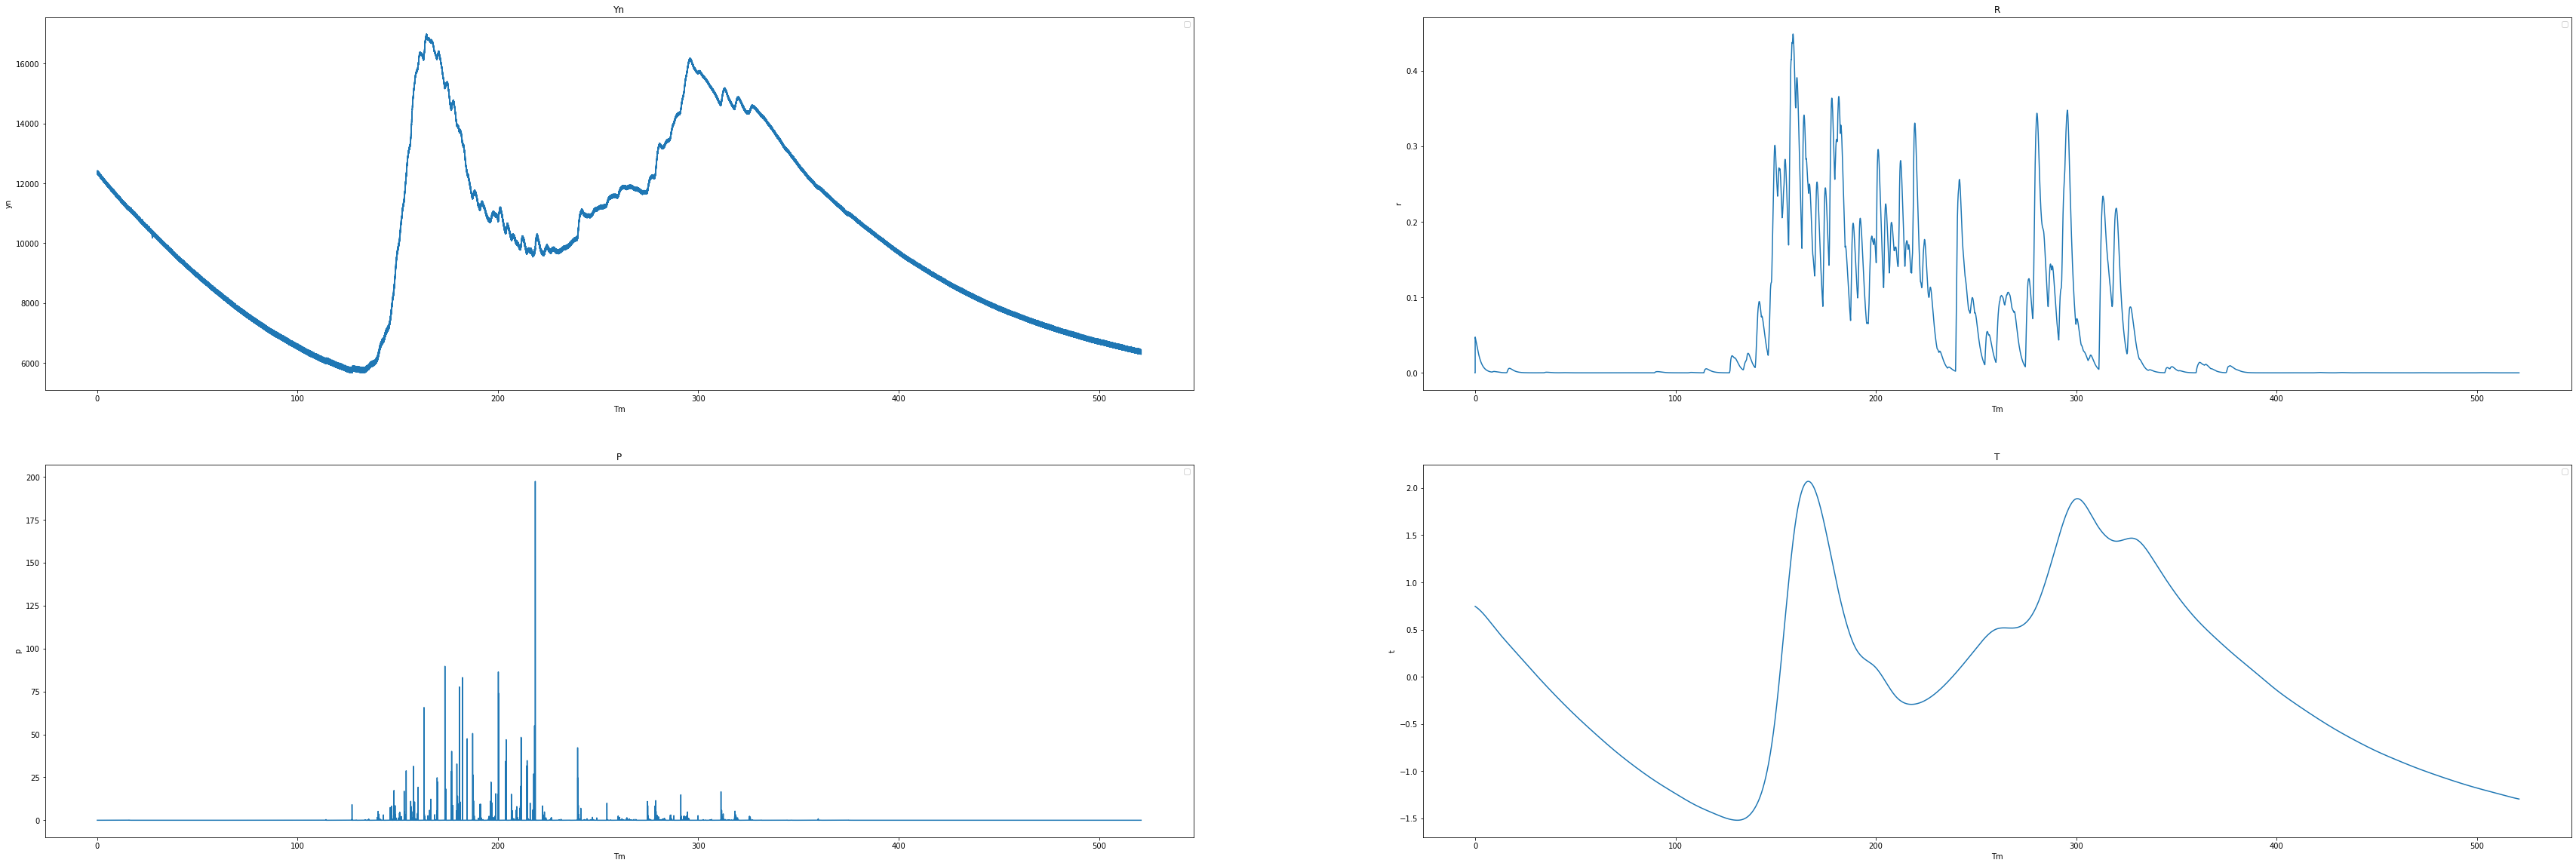

     pcost       dcost       gap    pres   dres
 0: -2.5063e+05 -2.5020e+05  5e+05  7e+02  5e+01
 1: -2.5022e+05 -2.6474e+05  1e+04  2e+01  1e+00
 2: -2.5022e+05 -2.5289e+05  3e+03  3e+00  2e-01
 3: -2.5018e+05 -2.5143e+05  1e+03  1e+00  6e-02
 4: -2.5025e+05 -2.5068e+05  4e+02  5e-02  3e-03
 5: -2.5052e+05 -2.5065e+05  1e+02  1e-02  8e-04
 6: -2.5056e+05 -2.5065e+05  8e+01  6e-03  4e-04
 7: -2.5060e+05 -2.5064e+05  4e+01  3e-03  2e-04
 8: -2.5062e+05 -2.5064e+05  2e+01  1e-03  8e-05
 9: -2.5063e+05 -2.5064e+05  9e+00  3e-04  2e-05
10: -2.5063e+05 -2.5064e+05  5e+00  8e-05  5e-06
11: -2.5064e+05 -2.5064e+05  2e+00  2e-05  1e-06
12: -2.5064e+05 -2.5064e+05  2e+00  2e-05  1e-06
13: -2.5064e+05 -2.5064e+05  6e-01  3e-06  2e-07
14: -2.5064e+05 -2.5064e+05  6e-01  2e-06  2e-07
15: -2.5064e+05 -2.5064e+05  2e-01  6e-07  8e-08
16: -2.5064e+05 -2.5064e+05  2e-01  4e-07  5e-08
17: -2.5064e+05 -2.5064e+05  9e-02  1e-07  5e-08
18: -2.5064e+05 -2.5064e+05  8e-02  1e-07  5e-08
19: -2.5064e+05 -2.50

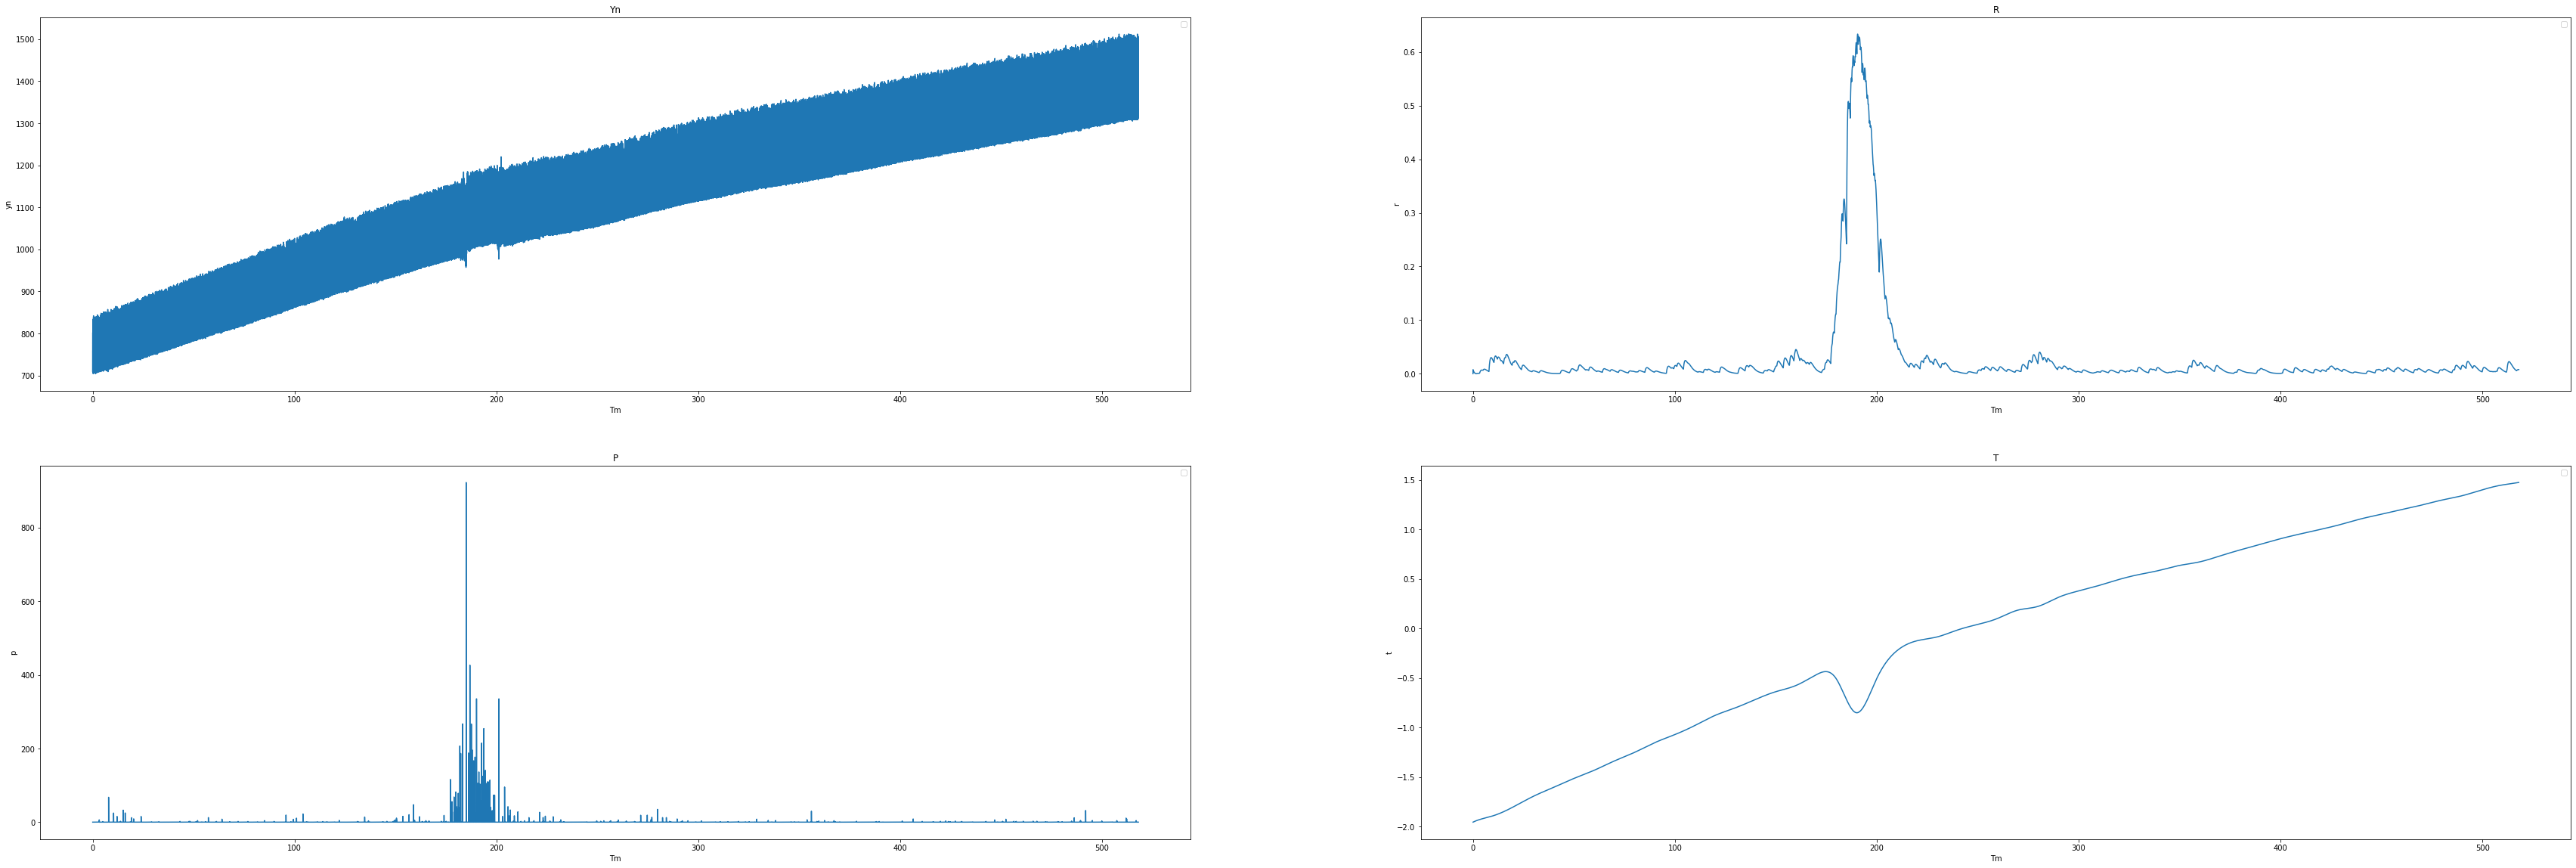

In [8]:
def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing
    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).
    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters
    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))

def plotCVxEDA():
    for i in range(len(dataplot[1])):
        y = np.array(dataplot[1][i])
        yn = stats.zscore(y)
        Fs = 1000
        [r, p, t, l, d, e, obj] = cvxEDA(yn, 1/Fs)
        tm = np.linspace(0, len(y)//1000, len(y))

        fig = plt.figure(figsize=(60,20), facecolor="white")
        plt.subplot(2, 2, 1)
        plt.plot(tm, y)
        plt.title('Yn')
        plt.xlabel('Tm')
        plt.ylabel('yn')
        plt.legend()
        plt.subplot(2, 2, 2)
        plt.plot(tm, r)
        plt.title('R')
        plt.xlabel('Tm')
        plt.ylabel('r')
        plt.legend()
        plt.subplot(2, 2, 3)
        plt.plot(tm, p)
        plt.title('P')
        plt.xlabel('Tm')
        plt.ylabel('p')
        plt.legend()
        plt.subplot(2, 2, 4)
        plt.plot(tm, t)
        plt.title('T')
        plt.xlabel('Tm')
        plt.ylabel('t')
        plt.legend()
        plt.show()
        fig.savefig(f'CVxEDA{i+1}bis.png', facecolor="white")

plotCVxEDA()

# Explication de cvxEDA

Electrodermal Activity (EDA) représente l'activité électrique de la peau.

On la mesure à l'aide de la conductance, et ses signaux sont une manifestation de l'activité des glande sudoripare (agissant sur la sueur) innervée par le système nerveux autonome.

Lorsque les nerfs sudomoteurs stimulent la production de sueur, la conductivité mesurée à la surface de la peau se modifie en raison de la sécrétion de sueur et des variations de perméabilité ionique des membranes des glandes sudoripares.

La conductance mesurée y est considérée comme une somme de 3 signaux : 
 * Une composante phasique r représentant la réponse courte suite aux stimuli
 * Une composante tonique t incluant les dérives lentes de la ligne de base et des fluctuations spontanées
 * Un bruit d'origine Gaussien

En considérant le problème comme un problème d'optimisation convexe quadratique, on obtient la forme de ses différentes composantes ainsi que l'activité des nerfs neuromoteurs p

In [ ]:
import heartpy
def plotECG(start=None, stop=None):
    Fs = 1000.0
    fig = plt.figure(figsize=(60,20), facecolor="white")
    for i in range(len(dataplot[0])):
        if start or stop:
            ecg = np.array(dataplot[0][i][start:stop])
        else:
            ecg = np.array(dataplot[0][i])
        ecg2 = heartpy.filtering.filter_signal(np.ravel(ecg), cutoff = 0.01, sample_rate = Fs, filtertype = 'notch')
        ecg2 = stats.zscore(ecg2)
        tm = np.linspace(0, len(ecg)//1000, len(ecg))
        if start or stop:
            tm2 = np.linspace(start//1000, stop//1000, len(ecg2))
        else: 
            tm2 = np.linspace(0, len(ecg2)//1000, len(ecg2))
        plt.subplot(4, 2, i+1)
        """ plt.plot(tm, ecg)
        plt.title(f'ecg Acquisition')
        plt.xlabel('Acquistition')
        plt.ylabel(f'ecg Value')
        plt.legend()
        plt.subplot(2, 1, 2) """
        plt.plot(tm2, ecg2)
        plt.title(f'ecg2 Acquisition {i+1}')
        plt.xlabel('Acquistition')
        plt.ylabel(f'ecg2 Value {i+1}')
        plt.legend()
    plt.show()
    fig.savefig(f"data{start}_{stop}.png")
plotECG()
plotECG(30000,40000)